# Real World P-Dispersion Problem

*Authors:* [Erin Olson](https://github.com/erinrolson), [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)

In [2]:
import geopandas
import pandas
import pulp
from shapely.geometry import Point
import matplotlib.pyplot as plt
import time

The problem is composed by 2 datafiles
- facility_points represents the stores that are candidate facility sites
- tract is the polygon of census tract 205.

All datasets are available online in this [repository](https://github.com/huanfachen/Open_source_location_cover_models/tree/master/Data/San_Francisco_store)

In [3]:
DIRPATH = "../spopt/tests/data/"

facility_points = pandas.read_csv(DIRPATH + "SF_store_site_16_longlat.csv", index_col=0)
study_area = geopandas.read_file(DIRPATH + "ServiceAreas_4.shp").dissolve()

Display facility_points dataframe

In [4]:
display(facility_points)

,OBJECTID,NAME,long,lat
1,1,Store_1,-122.510018,37.772364
2,2,Store_2,-122.488873,37.753764
3,3,Store_3,-122.464927,37.774727
4,4,Store_4,-122.473945,37.743164
5,5,Store_5,-122.449291,37.731545
6,6,Store_6,-122.491745,37.649309
7,7,Store_7,-122.483182,37.701109
8,8,Store_11,-122.433782,37.655364
9,9,Store_12,-122.438982,37.719236
10,10,Store_13,-122.440218,37.745382


Plot tract

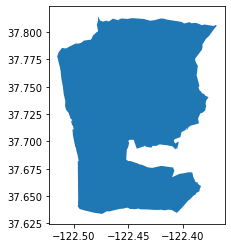

In [5]:
study_area.plot()

Now, as the rows and columns of our cost_matrix are sorted, so we have to sort our facility points and demand points geodataframes too. 

In [14]:
facility_points_gdf = geopandas.GeoDataFrame(
    facility_points,geometry=geopandas.points_from_xy(
    facility_points.long, facility_points.lat))
facility_points_gdf

,OBJECTID,NAME,long,lat,geometry
1,1,Store_1,-122.510018,37.772364,POINT (-122.51002 37.77236)
2,2,Store_2,-122.488873,37.753764,POINT (-122.48887 37.75376)
3,3,Store_3,-122.464927,37.774727,POINT (-122.46493 37.77473)
4,4,Store_4,-122.473945,37.743164,POINT (-122.47395 37.74316)
5,5,Store_5,-122.449291,37.731545,POINT (-122.44929 37.73155)
6,6,Store_6,-122.491745,37.649309,POINT (-122.49175 37.64931)
7,7,Store_7,-122.483182,37.701109,POINT (-122.48318 37.70111)
8,8,Store_11,-122.433782,37.655364,POINT (-122.43378 37.65536)
9,9,Store_12,-122.438982,37.719236,POINT (-122.43898 37.71924)
10,10,Store_13,-122.440218,37.745382,POINT (-122.44022 37.74538)


Below, the method is used to plot the results of the four models that we will prepare to solve the problem.

In [12]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines
from matplotlib_scalebar.scalebar import ScaleBar

dv_colors = [
    "saddlebrown",
    "darkgoldenrod",
    "mediumseagreen",
    "lightskyblue",
    "lavender",
    "darkslategray",
    "coral",
    "mediumvioletred",
    "darkcyan",
    "cyan",
    "limegreen",
    "peachpuff",
    "blueviolet",
    "fuchsia",
    "thistle",
]

def plot_results(model, facility_points_gdf, facility_count, title, p):
    
    arr_points = [] 
    fac_sites = [] 
    
    for i in range(facility_count):
        if model.fac2cli[i]:
            geom = 'test'#!demand_points_gdf.iloc[model.fac2cli[i]]["geometry"]
            arr_points.append(geom)
            fac_sites.append(i)

    
    fig, ax = plt.subplots(figsize=(10, 15))
    legend_elements = []

    study_area.plot(ax=ax, alpha=.5, fc="tan", ec="k", zorder=1)
    _patch = Patch(alpha=.5, fc="tan", ec="k", label="Dissolved Service Areas")
    legend_elements.append(_patch)

    facility_points_gdf.plot(
        ax=ax, fc="brown", marker="*", markersize=80, zorder=8
    )
    legend_elements.append(
        mlines.Line2D(
            [],
            [],
            marker="*",
            markerfacecolor="brown",
            markeredgecolor="brown",
            markeredgewidth=.5, 
            ms=20,
            lw=0,
            label=f"Unselected Candidate Store sites ($n$={facility_count})"
        )
    )

    _zo, _ms = 4, 4
    
    for i in range(len(arr_points)):

        cset = dv_colors[i]
        fac = fac_sites[i] 
        fname = facility_points_gdf.iloc[[fac]]["NAME"]
        fname = f"{fname.squeeze().replace('_', ' ')}"
        
        gdf = geopandas.GeoDataFrame(arr_points[i])
        
        label = f"Demand sites covered by {fname}"
        gdf.plot(ax=ax, zorder=_zo, ec="k", fc=cset, markersize=100*_ms, lw=.5,) 
        legend_elements.append(
            mlines.Line2D(
                [],
                [],
                marker="o",
                markerfacecolor=cset,
                markeredgecolor="k",
                markeredgewidth=.5, 
                ms= _ms + 7,
                lw=0,
                label=label
            )
        )
        
        facility_points_gdf.iloc[[fac]].plot(
            ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec="k", lw=.5
        )
        legend_elements.append(
            mlines.Line2D(
                [],
                [],
                marker="*",
                markerfacecolor=cset,
                markeredgecolor="k",
                markeredgewidth=.5,
                ms=20,
                lw=0,
                label=fname,
            )
        )
        
        _zo += 1
        _ms -= (1)*(4/p)
     
    plt.title(title, fontsize=20)
    kws = dict(loc="upper left", bbox_to_anchor=(1.05, .7), fontsize=15)
    plt.legend(handles=legend_elements, **kws)
    
    x, y, xyc, arrow_length, c = 0.925, 0.15, "axes fraction", 0.1 , "center"
    xy, xyt = (x, y), (x, y-arrow_length)
    ap = dict(facecolor="black", width=5, headwidth=10)
    kws = dict(arrowprops=ap, ha=c, va=c, fontsize=20)
    plt.annotate("N", xy=xy, xycoords=xyc, xytext=xyt, **kws)
    
    plt.gca().add_artist(ScaleBar(1))

## P-Dispersion

In [13]:
from spopt.locate import PDispersion

In [15]:
start_1 = time.time()
p=4
p_dispersion = PDispersion.from_geodataframe(facility_points_gdf, "geometry", p, distance_metric="euclidean")
end_1 = time.time()

time_spent_1 = end_1 - start_1

In [19]:
solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)
start_2 = time.time()
p_dispersion = p_dispersion.solve(solver) 
end_2 = time.time()

time_spent_2 = end_2 - start_2
total_time = time_spent_1 + time_spent_2

In [21]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines

dv_colors = [
    "darkcyan",
    "mediumseagreen",
    "cyan",
    "darkslategray",
    "lightskyblue",
    "limegreen",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "thistle",
    "lavender",
    "saddlebrown",
] 

def plot_results(model, facility_points, title):
    fac_sites = []
    
    for i in range(16):
        if model.fac_vars[i].varValue == 1:
            fac_sites.append(i)
    sited_facilities = range(len(fac_sites))

    fig, ax = plt.subplots(figsize=(6, 6))
    legend_elements = []

    facility_points.plot(ax=ax, color='brown', marker="*", markersize=80, zorder=2)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='brown',
        marker="*",
        linewidth=0,
        label=f'facility sites ($n$={16})'
    ))

    for i in sited_facilities:

        facility_points.iloc[[fac_sites[i]]].plot(ax=ax,
                                marker="*",
                                markersize=200 * 3.0,
                                alpha=0.8,
                                zorder=4,
                                edgecolor="k",
                                facecolor=dv_colors[i])
        
    for i in sited_facilities:
        legend_elements.append(mlines.Line2D(
        [],
        [],
        color=dv_colors[i],
        marker="*",
        ms=20 / 2,
        markeredgecolor="k",
        linewidth=0,
        alpha=0.8,
        label=f"y{fac_sites[i]} facility selected",
    ))

    plt.title(title, fontweight="bold")
    plt.legend(handles = legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

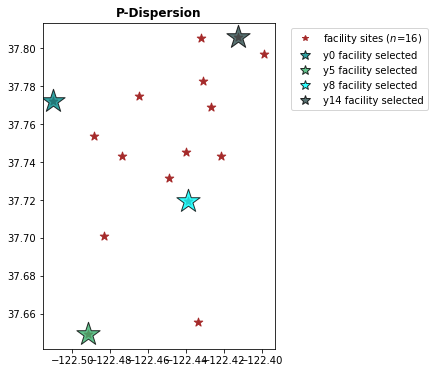

In [23]:
#!plot_results(p_dispersion, facility_points_gdf, facility_points_gdf.shape[0], "P-Dispersion", p)
plot_results(p_dispersion, facility_points_gdf, "P-Dispersion")

## PDispersion San Francisco Case Study Results

In [25]:
print(f"San Francisco Dataset \nCandidate Facilities: 16    Number of Facilities Solved for: {p}   Computation Time: {total_time}")

San Francisco Dataset 
Candidate Facilities: 16    Number of Facilities Solved for: 4   Computation Time: 0.2609848976135254
